In [ ]:
import pandas as pd
import numpy as np
from copy import copy
import torch
import matplotlib.pyplot as plt

from google.colab import drive
from IPython.display import clear_output

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_path = '/content/drive/MyDrive/CourseWork Resource/ML/'

In [ ]:
def file_to_data(filename):
    
    # read file
    raw = pd.read_csv(filename)
    
    # define columns to be extracted
    ndvi_col = ['ndvi_mean'+str(i) for i in range(1, 24+1)] # ndvi_mean1, ..., ndvi_mean24
    savi_col = ['ndvi_mean'+str(i) for i in range(1, 24+1)] # ndvi_mean1, ..., savi_mean24
    evi_col = ['ndvi_mean'+str(i) for i in range(1, 24+1)] # ndvi_mean1, ..., evi_mean24

    # extract each feature
    ndvi_timeseries = raw[ndvi_col]
    savi_timeseries = raw[savi_col]
    evi_timeseries = raw[evi_col]
    
    # dimension stack
    data = np.dstack([ndvi_timeseries, savi_timeseries, evi_timeseries])
    
    # get only label
    label = raw.iloc[:, -1]
    
    return data, label

def data_to_lv1_x_y(data, labels):
    
    # export all X
    # but reclass the plant cane -> 100, ratoon cane -> 200
    target = copy(labels)
    target[target > 200] = 200
    target[(target < 200) & (target > 100)] = 100
    
    return data, target

def data_to_lv2_x_y(data, target):
    
    # export X plant which labels are 100-200
    X_plant = data[(target > 100) & (target <200)]
    
    # export X ratoon which labels are >200
    X_ratoon = data[target > 200]
    
    # export y plant which labels are 100-200
    y_plant = target[(target > 100) & (target < 200)]
    
    # export y ratoon which labels are >200
    y_ratoon = target[target > 200]
    
    return X_plant, y_plant, X_ratoon, y_ratoon

def label_encode(y):
    
    target = copy(y)
    # redefine the cane plantation label to be 1 - 24
    new_y = [int(str(label)[1:]) for label in target]
    
    return np.array(new_y)

In [ ]:
data_train, labels_train = file_to_data('/content/drive/MyDrive/CourseWork Resource/ML/training_data_1718.csv')
data_test, labels_test = file_to_data('/content/drive/MyDrive/CourseWork Resource/ML/training_data_1819.csv')

In [ ]:
X_train, y_train = data_to_lv1_x_y(data_train, labels_train)
X_test, y_test = data_to_lv1_x_y(data_test, labels_test)

In [ ]:
from sklearn.preprocessing import LabelEncoder

lu_encoder = LabelEncoder()

y_train = lu_encoder.fit_transform(y_train)
y_test = lu_encoder.transform(y_test)

In [ ]:
print(f'numeric class of y train: {np.unique(y_train)}')
print(f'numeric class of y test: {np.unique(y_test)}')

numeric class of y train: [ 0  1  2  3  4  5  6  7  8  9 10 11]
numeric class of y test: [ 0  1  2  3  4  5  6  7  8  9 10 11]


In [ ]:
y_train[y_train>9] = 10
y_test[y_test > 9] = 10

In [ ]:
print(f'numeric class of y train: {np.unique(y_train)}')
print(f'numeric class of y test: {np.unique(y_test)}')

numeric class of y train: [ 0  1  2  3  4  5  6  7  8  9 10]
numeric class of y test: [ 0  1  2  3  4  5  6  7  8  9 10]


In [ ]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

In [ ]:
shape = X_train.shape
print(Counter(y_train))

Counter({10: 12367, 0: 118, 1: 92, 2: 85, 4: 30, 5: 30, 7: 30, 9: 30, 8: 30, 3: 26, 6: 22})


In [ ]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_train.shape

(12860, 72)

In [ ]:
# instantiating the random over sampler 
ros = RandomOverSampler()
# resampling X, y
X_train, y_train = ros.fit_resample(X_train, y_train)

print(f'after oversampled-> X shape: {X_train.shape}')

after oversampled-> X shape: (136037, 72)


In [ ]:
X_train = X_train.reshape(X_train.shape[0], 24,3)
X_train.shape

(136037, 24, 3)

In [ ]:
print(Counter(y_train))

Counter({3: 12367, 4: 12367, 5: 12367, 7: 12367, 9: 12367, 8: 12367, 6: 12367, 2: 12367, 1: 12367, 0: 12367, 10: 12367})


In [ ]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split

def Xy_dataloader(X_numpy, y_numpy, batch_size=32):
    
    X_tensor = torch.tensor(X_numpy).float()
    y_tensor = torch.tensor(y_numpy).long()
    
    dataset = TensorDataset(X_tensor, y_tensor)

    loader = DataLoader(dataset, batch_size=batch_size,shuffle=True)
    
    return loader

In [ ]:
train_loader = Xy_dataloader(X_train, y_train, 64)
test_loader = Xy_dataloader(X_test, y_test, 32)

In [ ]:
import torch
from torch import nn

In [ ]:

class RNN_lv1(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        
        self.rnn = nn.LSTM(input_dim, hidden_dim, num_layers=1, batch_first=True)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
     
        
        #[batch size, seq len, embed dim]
        out, (hn, cn) = self.rnn(x)
        x = self.dropout(hn.squeeze(0))
        x = self.fc(x)
        
        return x

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cuda


In [ ]:
model = RNN_lv1(3, 512, 24).to(device)

In [ ]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=0.001) #<----changed to Adam
criterion = nn.CrossEntropyLoss() #combine sigmoid with binary cross entropy

In [ ]:
def train_model(model, train_dataloader, valid_dataloader, 
                epochs, criterion, optimizer, print_epoch=1000):
    
    loss_train = []
    loss_valid = []
    acc_train = []
    acc_valid = []
    
    for i in range(1, epochs+1):
        
        # ===================TRAIN ======================
        model.train()
        
        epoch_loss = 0
        correct = 0
        
        for x, y in train_dataloader:
            
            x = x.to(device)
            y = y.to(device)
            
            out = model(x)
            
            loss = criterion(out, y)
            
            _,pred = torch.max(out, 1)
            
            correct += (pred == y).to('cpu').float().sum()
            
            epoch_loss += loss.item()
            
            #backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        acc_train.append(100 * correct / len(train_dataloader.dataset))
        loss_train.append(epoch_loss/len(train_dataloader))
        # loss_train.append(epoch_loss)
        
        # ===================VALIDATION =================
        model.eval()
    
        epoch_loss = 0
        correct = 0
        
        for x, y in valid_dataloader:
            
            x = x.to(device)
            y = y.to(device)
            
            out = model(x)
            
            loss = criterion(out, y)
            
            _,pred = torch.max(out, 1)
            
            correct += (pred == y).to('cpu').float().sum()
            
            epoch_loss += loss.item()
        
        acc_valid.append(100 * correct / len(valid_dataloader.dataset))
        loss_valid.append(epoch_loss/len(valid_dataloader))
        # loss_valid.append(epoch_loss)
        
        # ================= PRINT ===========================
        if i % print_epoch == 0 :
            clear_output(wait=True)
            print(f'epoch {i}/{epochs} train loss: {np.round(loss_train[-1],5)} train acc: {np.round(acc_train[-1],5)} validation loss: {np.round(loss_valid[-1],5)} validation acc: {np.round(acc_valid[-1],5)}')
            plt.plot(loss_train, label='train')
            plt.plot(loss_valid, label='test')
            plt.title('Loss during Training')
            plt.xlabel('epoch')
            plt.ylabel('loss')
            plt.legend()
            plt.show()

            plt.plot(acc_train, label='train')
            plt.plot(acc_valid, label='test')
            plt.title('Accuracy during Training')
            plt.xlabel('epoch')
            plt.ylabel('accuracy')
            plt.legend()
            plt.show()    
            
    return model, loss_train, loss_valid, acc_train, acc_valid
            

epoch 50/100 train loss: 0.00171 train acc: 99.95516204833984 validation loss: 0.06006 validation acc: 99.04342651367188


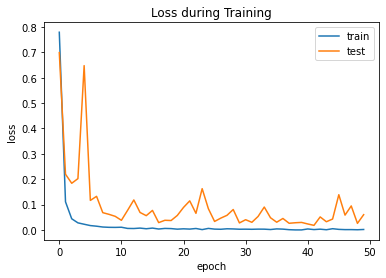

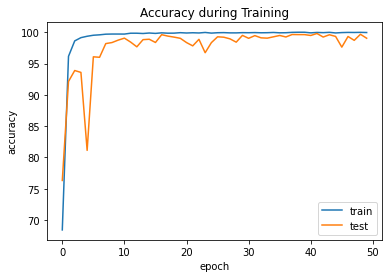

KeyboardInterrupt: ignored

In [ ]:
model, loss_train, loss_valid, acc_train, acc_valid = train_model(model, train_loader, test_loader, 100, criterion, optimizer, 10)

In [ ]:
def predict_model(model, X_test):
    
    model.eval()
    
    x = torch.tensor(X_test).float()
    
    x = x.to(device)
            
    out = model(x).to('cpu')
    
    pred = torch.max(out, 1)[1].numpy()
    
    return pred

In [ ]:
y_pred = predict_model(model, X_test)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       118
           1       1.00      1.00      1.00        92
           2       1.00      1.00      1.00        85
           3       0.87      1.00      0.93        26
           4       0.94      1.00      0.97        30
           5       0.44      1.00      0.61        30
           6       1.00      1.00      1.00        22
           7       1.00      1.00      1.00        30
           8       1.00      1.00      1.00        30
           9       1.00      1.00      1.00        30
          10       1.00      0.99      1.00      7452

    accuracy                           0.99      7945
   macro avg       0.93      1.00      0.96      7945
weighted avg       1.00      0.99      1.00      7945



In [ ]:
drive.flush_and_unmount()